# Proyecto Optimización

Importamos las librerías que vamos a utilizar en la solución del problema.

In [ ]:
import numpy as np
import time
from scipy.spatial import distance_matrix
from gurobipy import *
from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, Point
from numpy import random
from matplotlib import pyplot as plt
from sklearn.datasets import make_moons

Empezamos por definir las funciones que vamos a implementar:

In [ ]:
def generate_candidate_sites(points,M=100):
    '''
    Genera M candidatos de routers en la clausura convexa
    Entradas:
        points: un arreglo de Numpy de tamaño [N,2]
        M: El número de candidatos a generar
    Salida:
        sites: un arreglo de Numpy de tamaño [N,2]
    '''
    hull = ConvexHull(points)
    polygon_points = points[hull.vertices]
    poly = Polygon(polygon_points)
    min_x, min_y, max_x, max_y = poly.bounds
    sites = []
    while len(sites) < M:
        random_point = Point([random.uniform(min_x, max_x),
                             random.uniform(min_y, max_y)])
        if (random_point.within(poly)):
            sites.append(random_point)
    return np.array([(p.x,p.y) for p in sites])

def mclp(points,K,radius,M):
    """
    Solver de Maximum Covering Location Problem
    Entradas:
        points: puntos considerados en el problema en 
            un arreglo de numpy de tamaño [N,2]
        K: Número de sitios seleccionados
        radius: Radio de los circulos
        M: Número de sitios candidatos, que serán generados 
            aleatoriamente dentro de la envolvente conexa del pologono
    Return:
        opt_sites: K puntos de localización que solucionan el MCLP en
            un arreglo Numpy de tamaño [N,2]
        f: El valor óptimo de nuestra función objetivo
    """
    print('----- Configuraciones -----')
    print('  Número de puntos = %g' % points.shape[0])
    print('  Routers = %g' % K)
    print('  Radio de alcance %g m' % radius)
    print('  M = %g' % M)
    radius = radius/Escala
    start = time.time()
    sites = generate_candidate_sites(points, M)
    J = sites.shape[0]
    I = points.shape[0]
    D = distance_matrix(points,sites)
    mask1 = D<=radius
    D[mask1]=1
    D[~mask1]=0
    # Construimos el modelo
    m = Model()
    # Agregamos las variables
    x = {}
    y = {}
    for i in range(I):
      y[i] = m.addVar(vtype=GRB.BINARY, name="y%d" % i)
    for j in range(J):
      x[j] = m.addVar(vtype=GRB.BINARY, name="x%d" % j)

    m.update()
    # Agregamos las restricciones
    m.addConstr(quicksum(x[j] for j in range(J)) == K)

    for i in range(I):
        m.addConstr(quicksum(x[j] for j in np.where(D[i]==1)[0]) >= y[i])

    m.setObjective(quicksum(y[i]for i in range(I)),GRB.MAXIMIZE)
    m.setParam('OutputFlag', 0)
    m.optimize()
    end = time.time()
    print('----- Salidas -----')
    print('  Tiempo de ejecución : %s Segundos' % float(end-start))
    print('  Puntos cubiertos = %g' % m.objVal)
    
    solution = []
    if m.status == GRB.Status.OPTIMAL:
        for v in m.getVars():
            # print v.varName,v.x
            if v.x==1 and v.varName[0]=="x":
               solution.append(int(v.varName[1:]))
    opt_sites = sites[solution]
    return opt_sites,m.objVal

def plot_input(points):
    '''
    Plot the result
    Entradas:
        points: Puntos iniciales en un arreglo de 
            numpy de tamaño [N,2]
        opt_sites: K puntos de localización que solucionan el MCLP en
            un arreglo Numpy de tamaño [N,2]
    '''
    fig = plt.figure(figsize=(8,8))
    plt.scatter(points[:,0],points[:,1],c='C0')
    ax = plt.gca()
    ax.axis('equal')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)

def plot_result(points, opt_sites, radius):
    '''
    Graficamos el resultado
    Entradas:
        points: puntos de las personas en un arreglo de Numpy de la forma [N,2]
        opt_sites: puntos de localización de los routers en un arreglo de la forma [N,2]
        radius: radio de alcance
    '''
    fig = plt.figure(figsize=(10,10))
    plt.scatter(points[:,0],points[:,1],c='C0')
    ax = plt.gca()
    plt.scatter(opt_sites[:,0],opt_sites[:,1],c='C1',marker='+')
    for site in opt_sites:
        circle = plt.Circle(site, radius, color='C1',fill=False,lw=2)
        ax.add_artist(circle)
    ax.axis('equal')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)


# Desarrollamos

Manejamos una escala de 1:1510.35 

In [ ]:
# Definimos la escala
Escala = 1510.35

Los puntos a considerar van a seguir una distribución normal considerando dos varianzas $var$ para edificios pequeños y $var1$ para edificios grandes, determinado por su cantidad de estudiantes activos siendo grande cuando más de 500 personas tienen clase ahí.

In [ ]:
var = 13/Escala
var1= 22/Escala

Esto quiere decir que para $var$ tenemos que el 68.26\% de los puntos van a encontrarse en un radio de 15 metros del centro del edificio, de forma análoga con $var1$.

Con ayuda de la referencia [15] en la cual encontramos un mapa de la Universidad Nacional de Colombia sede Bogotá definimos los puntos centrales de los edificios que encontramos en el Cuadro 1. del documento.

In [ ]:
#Definimos los puntos de la siguiente forma [x, y, varianza, N-personas]
Dere = [0.6054622,0.2751296,var1,604]
Socio = [0.6016333,0.2030057,var,320]
Odonto = [0.5001624,0.2078420,var,231]
Cienchum = [0.5360857,0.1697381,var1,570]
Ling = [0.5781098,0.1295113,var,213]
DiseñoGraf = [0.6574249,0.1145763,var,151]
ManuelAnc = [0.4848398,0.1297166,var,139]
PosCienchum = [0.4019050,0.1773550,var1,542]
Enfer = [0.5378150,0.2715150,var1,797]
Leng = [0.5575850,0.0913050,var,90]
Poscienc = [0.6543750,0.0721000,var,341]
Filo = [0.6436450,0.0562450,var,40]
Music = [0.7942787,0.2928381,var,127]
Constr = [0.8388681,0.3600925,var,143]
Ciencec = [0.8230903,0.4288243,var,341]
Ciencec2 = [0.8207031,0.4026937,var,341]
Sindu = [0.8455227,0.3237126,var,406]
Ing = [0.6749550,0.4079150,var1,347]
FEM = [0.7061134,0.4451184,var,302]
FEM2 = [0.7573266,0.4501641,var,302]
Extinv = [0.6932400,0.4975100,var1,350]
Posmater = [0.7092700,0.5434100,var,271]
Labenshid = [0.7887000,0.4800800,var,178]
Labhid = [0.7484500,0.5135200,var,178]
Labing = [0.6877400,0.5545100,var,350]
Ingquim = [0.6525100,0.5193200,var,117]
Bio = [0.7529600,0.6902400,var,105]
Gen = [0.6722600,0.8282800,var,105]
Famarc = [0.5596500,0.3999800,var,270]
Quim = [0.5985800,0.4360700,var,235]
Aulasing = [0.6090900,0.5001000,var,405]
CyT = [0.5398500,0.4647700,var1,405]
Med = [0.5682100,0.3476900,var1,517]
Veter = [0.4942800,0.3259900,var,76]
CiencAgrar = [0.3480000,0.3119200,var,293]
Cirug = [0.4541800,0.3333300,var,76]
Labhistop = [0.4665300,0.2952300,var,76]
Audit = [0.4699000,0.2602500,var,76]
Veter = [0.3262400,0.4249400,var,76]
Cine = [0.4790000,0.6401700,var,109]

# Hacemos una lista con cada una de las listas de información de los edificios
Fac = [Dere,Socio,Odonto,Cienchum,Ling,DiseñoGraf,ManuelAnc,PosCienchum,Enfer,Leng,Poscienc,Filo,Music,Constr,Ciencec,Ciencec2,Sindu,Ing,FEM,FEM2,Extinv,Posmater,Labenshid,Labhid,Labing,Ingquim,Bio,Gen,Famarc,Quim,Aulasing,CyT,Med,Veter,CiencAgrar,Cirug,Labhistop,Audit,Veter,Cine]

Reescalamos el dato de número de personas por edificio para optimizar el tiempo de ejecución de la solución

In [ ]:
for i in range(len(Fac)):
  Fac[i][3] = int(Fac[i][3] /2)

Ahora hacemos una función que nos permita generar puntos normalmente distribuidos alrededor de cada edificio y consideramos estos puntos

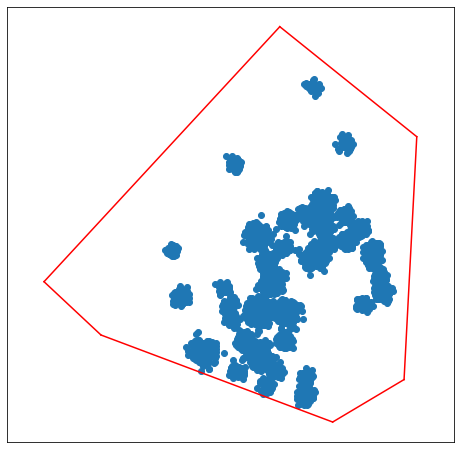

In [ ]:
# Definimos la función
def PuntosEdificio(L):
  R = np.zeros((L[3],2))
  Rx = np.random.normal(L[0], L[2], L[3])
  Ry = np.random.normal(L[1], L[2], L[3])
  for i in range(L[3]):
    for j in range(2):
      if(j==0):
        R[i,j] = Rx[i]
      if(j==1):
        R[i,j] = Ry[i]
  return R

# Agregamos los puntos con la información de los edificios
points,_ = make_moons(0)
for i in range(len(Fac)):
  L = PuntosEdificio(Fac[i])
  points = np.append(points, L, axis = 0)
    
# Imprimimos los puntos a considerar
plot_input(points)


# Definimos una función para dibujar el contorno de la universidad
def Dibujo():
    for i in range(len(Vertices)-1):
      x_values = [Vertices[i][0], Vertices[i+1][0]]
      y_values = [Vertices[i][1], Vertices[i+1][1]]
      plt.plot(x_values, y_values,'r')
    x_values = [Vertices[5][0], Vertices[0][0]]
    y_values = [Vertices[5][1], Vertices[0][1]]
    plt.plot(x_values, y_values,'r')
    plt.show()
    
# Definimos los vértices del poliedro que aproxima el campus
Vertices = [[0.5907200,0.9782300], 
            [0.9284800,0.7069300],
            [0.8971400,0.1080500],
            [0.7210700,0.0033000],  
            [0.1497500,0.2179200],
            [0.0092900,0.3493600]]
    
# Dibujamos el contorno de la universidad
Dibujo()

Ahora definimos los parámetros y solucionamos el problema

In [ ]:
# Números de routers
K = 10

# Radio de alcance de los routers
radio = 134.5 # En metros

# Sitios aleatorios generados opcionales para ubicar el router
M = 20000

# Corremos la función mclp que soluciona el problema
# opt_sites: ubicación de los routers
# f: número de puntos cubiertos
opt_sites, f = mclp(points, K, radio, M)

----- Configuraciones -----
  Número de puntos = 5259
  Routers = 10
  Radio de alcance 134.5 m
  M = 20000
Academic license - for non-commercial use only - expires 2021-09-25
Using license file C:\Users\Juand\gurobi.lic
----- Salidas -----
  Tiempo de ejecución : 130.4593789577484 Segundos
  Puntos cubiertos = 5210


<Figure size 7200x7200 with 0 Axes>

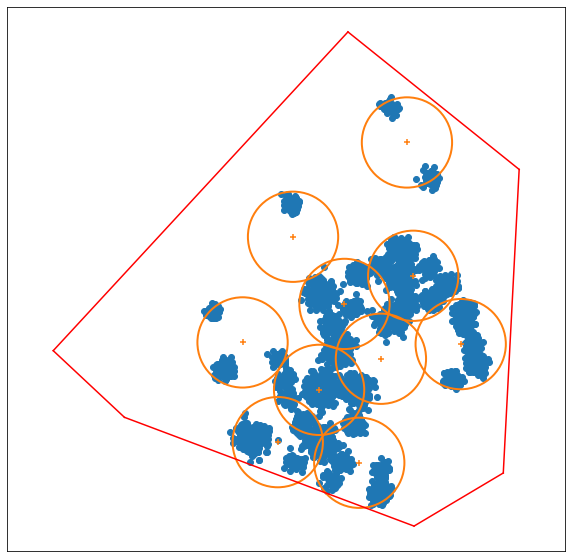

In [ ]:
# Imprimimos el resultado
plt.figure(figsize=(100, 100))
plot_result(points, opt_sites, radio/Escala)

# Dibujamos el poliedro que aproxima el campus
Dibujo()

Con lo cual el resultado, es decir los puntos donde se deben ubicar los routers son los siguientes

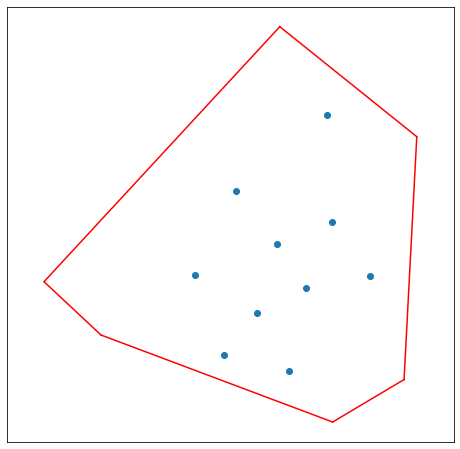

In [ ]:
plot_input(opt_sites)
Dibujo()

Ahora replicamos el experimento con diferentes cantidades de routers

----- Configuraciones -----
  Número de puntos = 5259
  Routers = 4
  Radio de alcance 134.5 m
  M = 20000
----- Salidas -----
  Tiempo de ejecución : 27.102494716644287 Segundos
  Puntos cubiertos = 3921


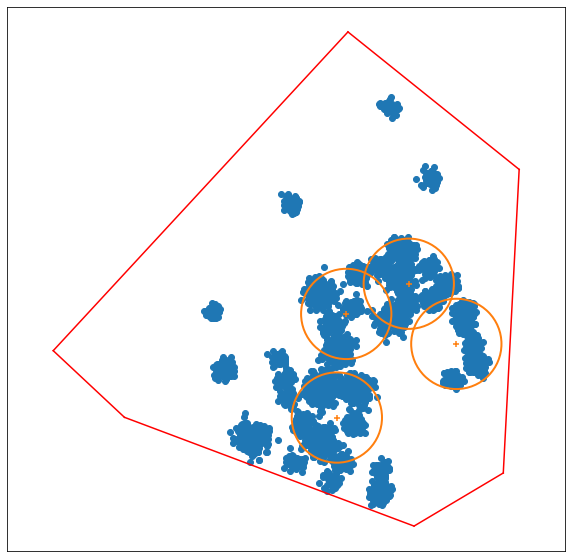

In [ ]:
L, f1 = mclp(points, 4, radio, M)
plot_result(points, L, radio/Escala)
Dibujo()

----- Configuraciones -----
  Número de puntos = 5259
  Routers = 5
  Radio de alcance 134.5 m
  M = 20000
----- Salidas -----
  Tiempo de ejecución : 124.38059663772583 Segundos
  Puntos cubiertos = 4409


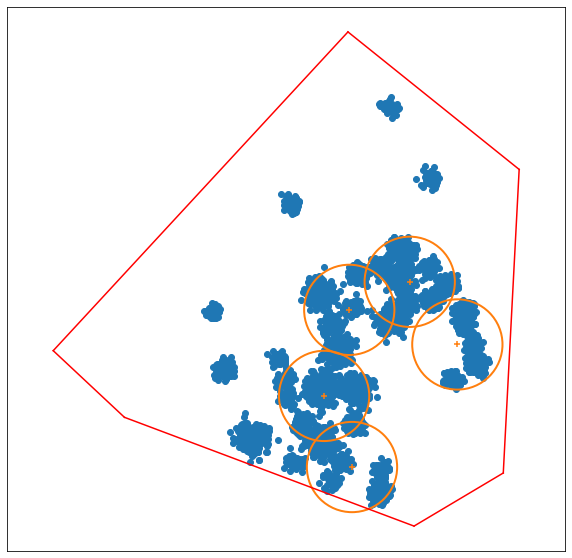

In [ ]:
L, f2 = mclp(points, 5, radio, M)
plot_result(points, L, radio/Escala)
Dibujo()

----- Configuraciones -----
  Número de puntos = 5259
  Routers = 6
  Radio de alcance 134.5 m
  M = 20000
----- Salidas -----
  Tiempo de ejecución : 131.28991389274597 Segundos
  Puntos cubiertos = 4815


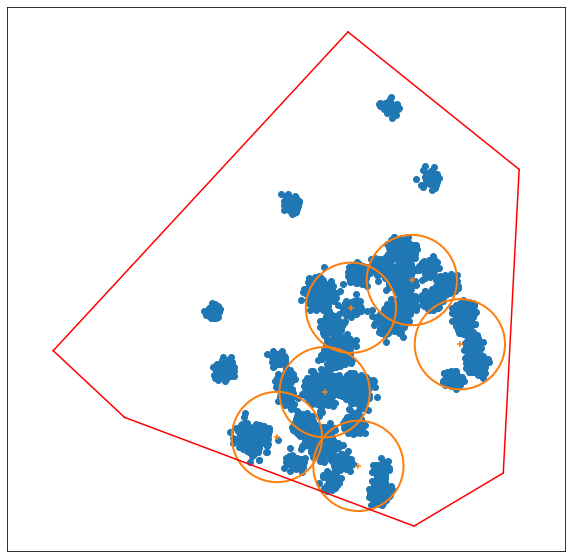

In [ ]:
L, f3 = mclp(points, 6, radio, M)
plot_result(points, L, radio/Escala)
Dibujo()

----- Configuraciones -----
  Número de puntos = 5259
  Routers = 7
  Radio de alcance 134.5 m
  M = 20000
----- Salidas -----
  Tiempo de ejecución : 131.10657477378845 Segundos
  Puntos cubiertos = 5019


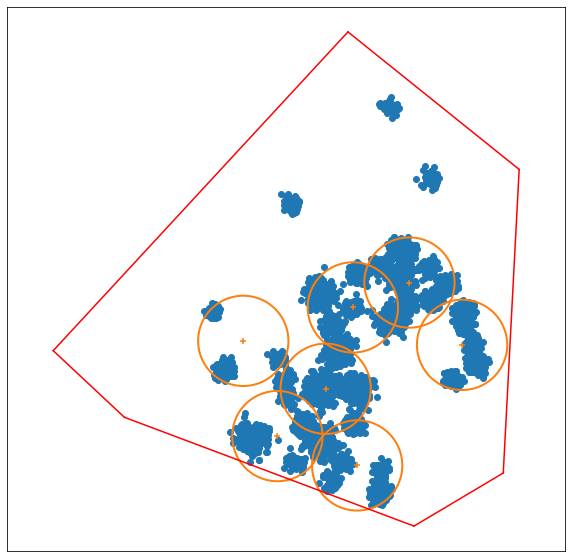

In [ ]:
L, f4 = mclp(points, 7, radio, M)
plot_result(points, L, radio/Escala)
Dibujo()

----- Configuraciones -----
  Número de puntos = 5259
  Routers = 8
  Radio de alcance 134.5 m
  M = 20000
----- Salidas -----
  Tiempo de ejecución : 123.62333154678345 Segundos
  Puntos cubiertos = 5099


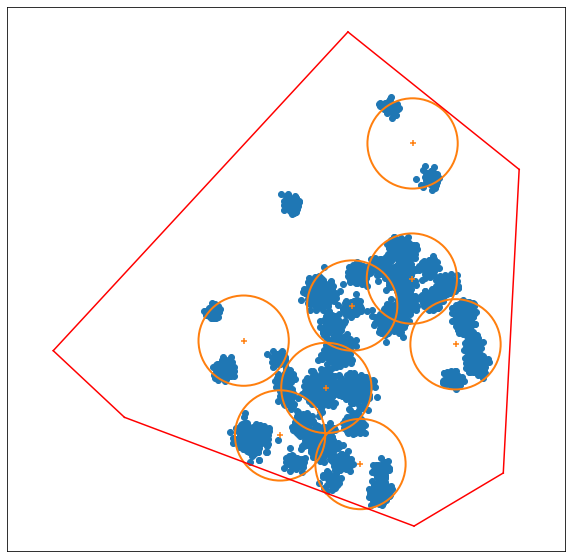

In [ ]:
L, f5 = mclp(points, 8, radio, M)
plot_result(points, L, radio/Escala)
Dibujo()

----- Configuraciones -----
  Número de puntos = 5259
  Routers = 9
  Radio de alcance 134.5 m
  M = 20000
----- Salidas -----
  Tiempo de ejecución : 122.94269514083862 Segundos
  Puntos cubiertos = 5156


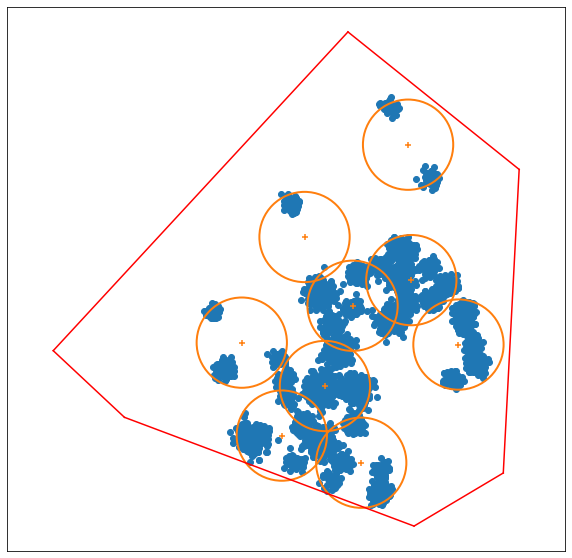

In [ ]:
L, f6 = mclp(points, 9, radio, M)
plot_result(points, L, radio/Escala)
Dibujo()

----- Configuraciones -----
  Número de puntos = 5259
  Routers = 10
  Radio de alcance 134.5 m
  M = 20000
----- Salidas -----
  Tiempo de ejecución : 129.10067462921143 Segundos
  Puntos cubiertos = 5206


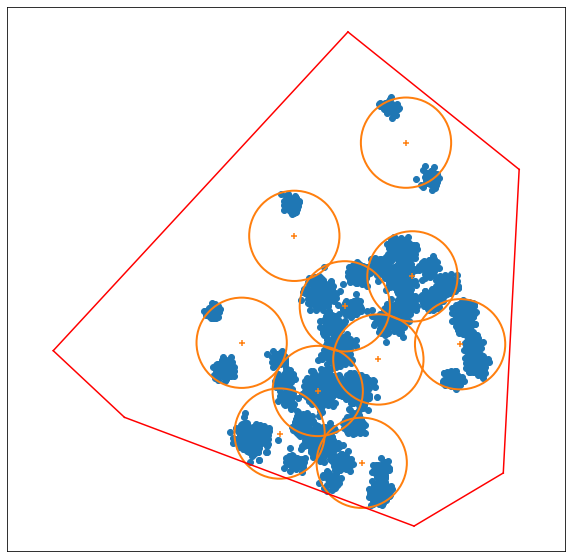

In [ ]:
L, f7 = mclp(points, 10, radio, M)
plot_result(points, L, radio/Escala)
Dibujo()

----- Configuraciones -----
  Número de puntos = 5259
  Routers = 11
  Radio de alcance 134.5 m
  M = 20000
----- Salidas -----
  Tiempo de ejecución : 93.60536813735962 Segundos
  Puntos cubiertos = 5239


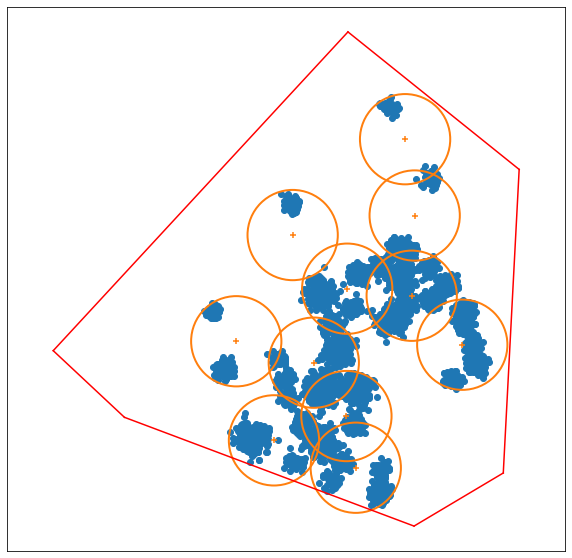

In [ ]:
L, f8 = mclp(points, 11, radio, M)
plot_result(points, L, radio/Escala)
Dibujo()

----- Configuraciones -----
  Número de puntos = 5259
  Routers = 12
  Radio de alcance 134.5 m
  M = 20000
----- Salidas -----
  Tiempo de ejecución : 121.11957836151123 Segundos
  Puntos cubiertos = 5259


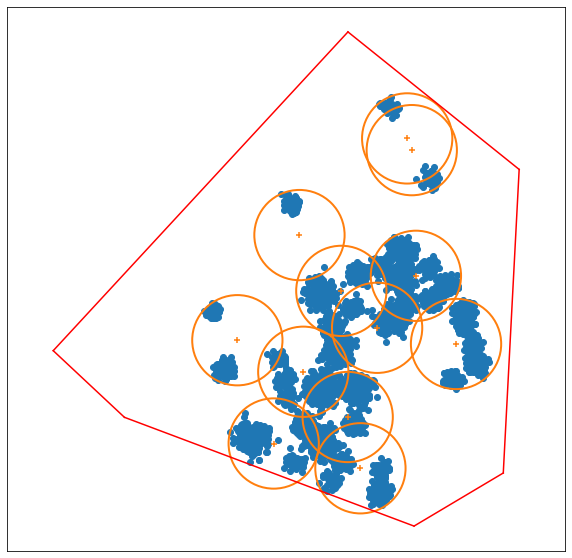

In [ ]:
L, f9 = mclp(points, 12, radio, M)
plot_result(points, L, radio/Escala)
Dibujo()